In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
dataset = pd.read_csv('ratings.csv')
dataset['movieId'].nunique()

9066

In [11]:
sparsity = dataset.shape[0]/(dataset['movieId'].nunique() * dataset['userId'].nunique())

In [13]:
print(sparsity)

0.016439141608663475


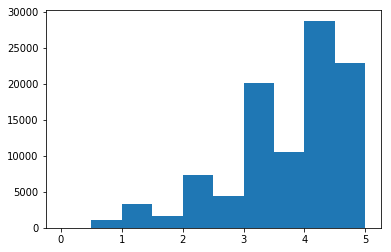

In [19]:
plt.hist(dataset['rating'],bins=np.arange(0, 5 + 0.5, 0.5))
plt.show()

In [21]:
from collections import Counter
movie_ids = dataset['movieId']
#Counter(movie_ids)

Counter({1: 247,
         2: 107,
         3: 59,
         4: 13,
         5: 56,
         6: 104,
         7: 53,
         8: 5,
         9: 20,
         10: 122,
         11: 82,
         12: 18,
         13: 8,
         14: 31,
         15: 11,
         16: 88,
         17: 86,
         18: 26,
         19: 92,
         20: 13,
         21: 95,
         22: 38,
         23: 22,
         24: 34,
         25: 101,
         26: 5,
         27: 7,
         28: 18,
         29: 40,
         30: 10,
         31: 42,
         32: 196,
         34: 148,
         35: 11,
         36: 104,
         37: 2,
         38: 2,
         39: 120,
         40: 6,
         41: 23,
         42: 9,
         43: 12,
         44: 38,
         45: 43,
         46: 12,
         47: 201,
         48: 61,
         65585: 5,
         50: 201,
         52: 51,
         53: 1,
         54: 3,
         55: 6,
         57: 14,
         58: 45,
         59: 2,
         60: 32,
         61: 7,
         62: 87,
      

In [42]:
movie_ratings_dict = dict(Counter(movie_ids))

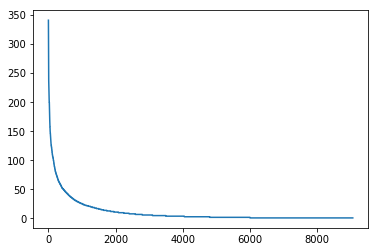

In [43]:
plt.plot(range(0,len(movie_ratings_dict.keys())), sorted(movie_ratings_dict.values(),reverse=True))

In [44]:
user_ids = dataset['userId']

In [45]:
user_ratings_dict = dict(Counter(user_ids))

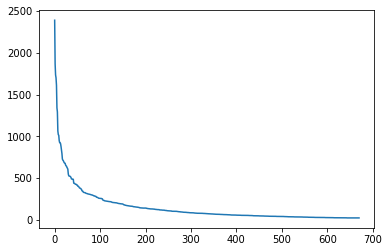

In [46]:
plt.plot(range(0,len(user_ratings_dict.keys())), sorted(user_ratings_dict.values(),reverse=True))

In [49]:
sum(sorted(user_ratings_dict.values(),reverse=True)[:100])

55141

In [75]:
var_list = list(dataset[['movieId','rating']].groupby('movieId').var()['rating'])

ValueError: range parameter must be finite.

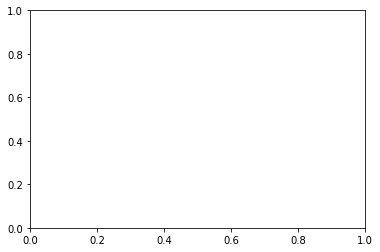

In [76]:
plt.hist(var_list,bins=np.arange(min(var_list), max(var_list), 0.5))
plt.show()

In [64]:
type(dataset['rating'])

pandas.core.series.Series

In [71]:
len(var_list)

9066

In [77]:
print(min(var_list), max(var_list))

0.0 10.125


In [79]:
print(var_list)

[0.91964550212303686, 0.77565685064362566, 1.322764465225015, 0.8814102564102565, 0.89967532467532441, 0.6904406273338316, 1.216436865021771, 2.6999999999999997, 0.66052631578947374, 0.59260262837013944, 0.80024841915085809, 1.2295751633986927, 0.9598214285714286, 0.6059139784946237, 0.81363636363636349, 0.77034352142110707, 0.86186730506155962, 1.4034615384615383, 1.1661490683229809, 1.6025641025641029, 1.0225643896976477, 0.93118776671408232, 0.89610389610389607, 1.3086007130124773, 1.1680693069306929, 0.79999999999999993, 0.47619047619047628, 0.65441176470588247, 0.65320512820512822, 0.91388888888888886, 0.70513937282229966, 0.69924123495552137, 1.1529233314947596, 0.67272727272727262, 0.65867718446601931, 2.0, 2.0, 0.92184873949579793, 0.64166666666666639, 0.91996047430830041, 0.5, 0.77840909090909105, 0.9126955903271694, 0.7732558139534883, 1.0606060606060608, 0.81378109452736336, 0.81530054644808714, 2.0, 0.53568407960198983, 0.83078431372549044, nan, 0.33333333333333337, 1.46666

In [82]:
np.isnan(dataset).values.any()

False

In [85]:
dataset[['movieId','rating']].groupby('movieId').var()

,rating
movieId,
1,0.919646
2,0.775657
3,1.322764
4,0.881410
5,0.899675
6,0.690441
7,1.216437
8,2.700000
9,0.660526


In [ ]:
dataset.loc[dataset['movieId']]